## Contents:
* [Loading packages](#Loading_packages)
* [Reading cell2location model output](#read)


* [Fig 4C](#Fig4C)

* [Fig 4F - B IFN & co-located cells](#Fig4F)
* [Fig 4G - binned pseudospace dotplot](#Fig4G) 


* [Supplementary pseudospace centered on FDC](#pseudospace_fdc)


* [Read saved sklearn colocated cell group model](#read_nmf)
* [Fig 4D - co-located cell groups - dotplot](#Fig4D_dotplot)
* [Fig 4D - Supplementary - matching clustering - dotplot](#Fig4D_suppl_clust)
* [Fig 4D - factor spatial](#Fig4D_spatial)

### Loading packages <a class="anchor" id="Loading_packages"></a>

In [1]:
# Import modules and packages:
%pylab inline
import pandas as pd
import sys, ast, os
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
import pickle as pickle
import numpy as np
import time
import itertools
data_type = 'float32'

#os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True'
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
import cell2location.models as c2l
import anndata
import scanpy as sc

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text

Populating the interactive namespace from numpy and matplotlib


### Reading cell2location model output <a class="anchor" id="read"></a>

In [2]:
# read a previously trained LocationModel
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/lymph_nodes_analysis/'
sp_results_folder = f'{results_folder}'
sc_results_folder = f'{results_folder}regression_model/'

scvi_run_name = 'signatures_lr0002_Adam_20kiter_c2l'
scvi_ref_run_name = 'signatures_lr0002_Adam_ref'
scvi_run_path = f'/nfs/team205/vk7/sanger_projects/BayraktarLab/scvi-tools/scvi/external/cell2location/tutorial/results/lymph_nodes_analysis/non_amortised/{scvi_run_name}/'
scvi_ref_run_path = f'/nfs/team205/vk7/sanger_projects/BayraktarLab/scvi-tools/scvi/external/cell2location/tutorial/results/lymph_nodes_analysis/non_amortised/{scvi_ref_run_name}/'

# path for saving figures
fig_path = f'{scvi_run_path}plots/figures/'
sc_figpath = sc.settings.figdir
sc.settings.figdir = f'{fig_path}'

adata_vis = sc.read_h5ad(f'{scvi_run_path}sp.h5ad')

# add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

adata_snrna_raw = sc.read_h5ad(f'{scvi_ref_run_path}sc.h5ad')
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_snrna_raw.varm.keys():
    regr_inf_aver = adata_snrna_raw.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                        for i in adata_snrna_raw.uns['mod']['factor_names']]].copy()
else:
    regr_inf_aver = adata_snrna_raw.var[[f'means_per_cluster_mu_fg_{i}' 
                                        for i in adata_snrna_raw.uns['mod']['factor_names']]].copy()
regr_inf_aver.columns = adata_snrna_raw.uns['mod']['factor_names']
regr_inf_aver.iloc[0:5, 0:5]

adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


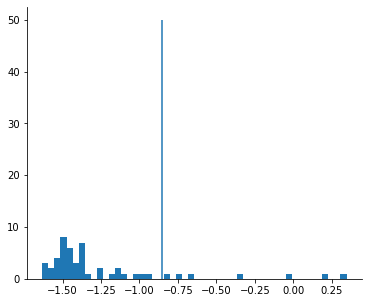

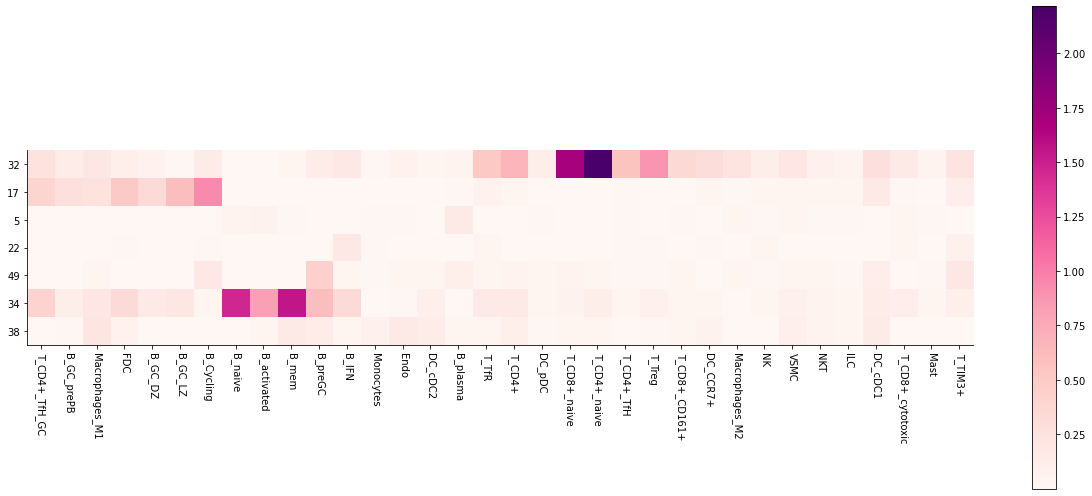

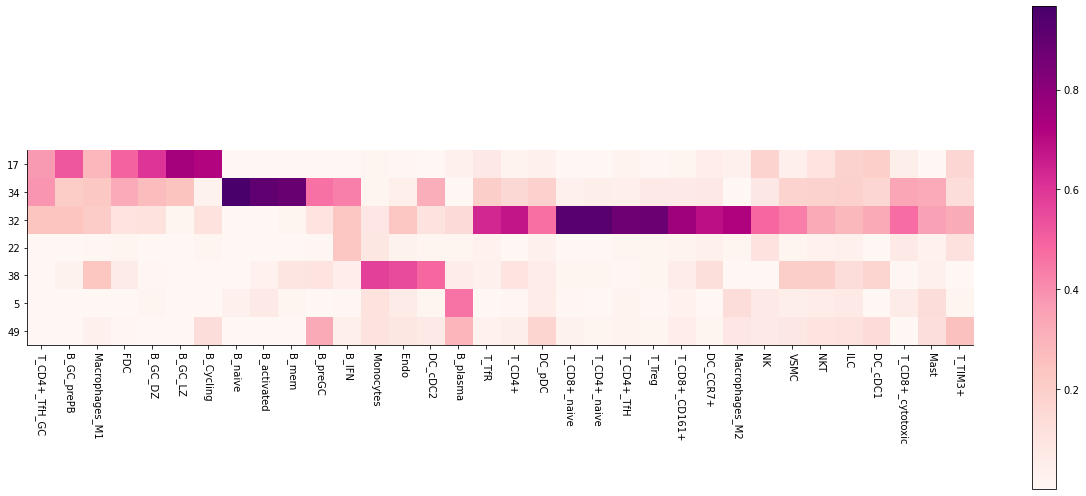

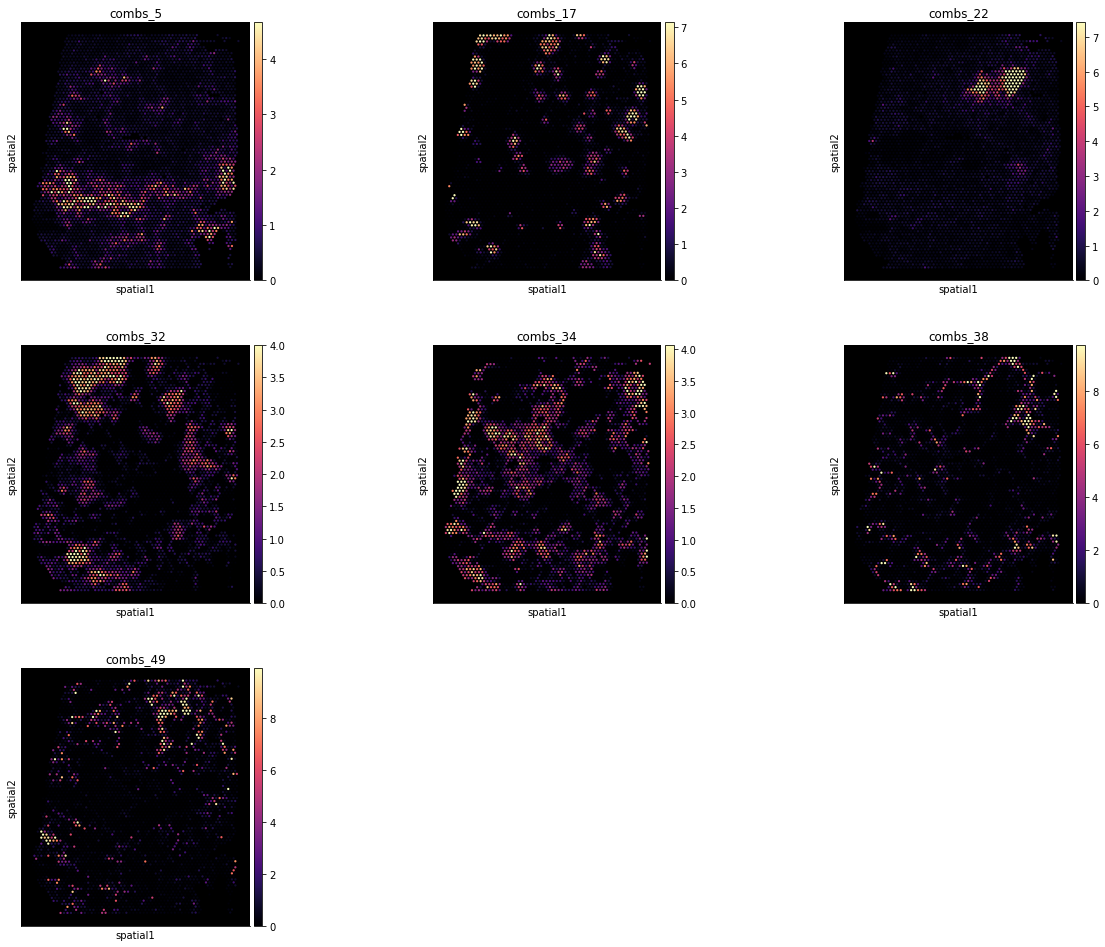

In [3]:
from cell2location.plt.plot_heatmap import clustermap
comb2fact_df = pd.DataFrame(adata_vis.uns['mod']['post_sample_means']['x_fr_group2fact'],
                            columns=adata_vis.uns['mod']['factor_names'])

rcParams["figure.figsize"] = [6, 5]
rcParams["axes.facecolor"] = "white"
plt.hist(np.log10(comb2fact_df.max(1)), bins=50);
thresh = 0.14
plt.vlines(np.log10(thresh), 0, 50);
fact_filt = comb2fact_df.max(1) > thresh

comb2fact_df = comb2fact_df.loc[fact_filt.values, :]

clustermap(comb2fact_df, figure_size=(17, 7))

comb2fact_df_prop = (comb2fact_df / comb2fact_df.sum(0))
clustermap(comb2fact_df_prop, figure_size=(17, 7))

n_combs = adata_vis.uns['mod']['post_sample_means']['z_sr_groups_factors'].shape[1]
combs_factors = pd.DataFrame(adata_vis.uns['mod']['post_sample_means']['z_sr_groups_factors'],
                             columns=[f'combs_{i}' for i in range(n_combs)],
                             index=adata_vis.uns['mod']['obs_names'])
combs_factors = combs_factors.loc[:, fact_filt.values]
adata_vis.obs[combs_factors.columns] = combs_factors


s = 'V1_Human_Lymph_Node'
rcParams["axes.facecolor"] = "black"
sc.pl.spatial(adata_vis[adata_vis.obs['sample'].isin([s]),:], cmap='magma',
              color=combs_factors.columns, # limit size in this notebook
              library_id=f'{s}',
              ncols=3, 
              size=1, img_key='hires', 
              alpha_img=0,
              vmin=0, vmax='p99.0'
             )

In [4]:
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes as inset_axes_func


def add_rectange_to_axis(ax, crop_coord, **kwargs):
    width = crop_coord[1] - crop_coord[0]
    height = crop_coord[2] - crop_coord[3]
    bottom_left = (crop_coord[0], crop_coord[3])
    
    kwargs = {'linewidth': 3,
             'edgecolor': 'r',
             'facecolor': 'none',
             'zorder': 10,
             **kwargs}
    
    rect = patches.Rectangle(bottom_left, width, height, **kwargs)
    ax.add_patch(rect)
    

def add_rectangle_to_fig(fig, crop_coord, **kwargs):
    for ax in fig.axes:
        if type(ax.get_aspect()) is str or ax.get_aspect() < 5:
            add_rectange_to_axis(ax, crop_coord, **kwargs)
            
def plot_1D_posterior(adata, x, ct_list, xlabel='', 
                      ylabel='Inferred cell density',
                      param='spot_factors', shaded_alpha=0.5,
                      show_points=False, point_size=0.5,
                      reorder_cmap=None, vlines=None):
    r""" Plot posterior of cell types and factors along some 1D gradient (e.g. diffusion pseudospace).
    This is done by computing LOESS function of the location-specific cell type density 
    and factor expression parameters (up to 7). Solid line shows the LOESS-smoothed function of the posterior mean, 
    shaded areas highlight 5% and 95% posterior quantiles highlighting cell type mapping uncertainty.
    """
    
    colors=[( 240/256, 228/256, 66/256),
            ( 213/256, 94/256, 0/256),
            ( 86/256, 180/256, 233/256),
            ( 0/256,158/256, 115/256),
            'purple',
            ( 200/256, 200/256, 200/256),
            ( 50/256, 50/256, 50/256)
           ]
    if reorder_cmap is not None:
        colors = [colors[i] for i in reorder_cmap]

    from statsmodels.nonparametric.smoothers_lowess import lowess

    for i, ct in enumerate(ct_list):
    
        y1_mean=adata.obs['mean_' + param + ct]
        y1_mean_s=lowess(y1_mean, x, return_sorted=False)
        y1_q05=adata.obs['q05_' + param + ct]
        y1_q05_s=lowess(y1_q05, x, return_sorted=False)
        y1_q95=adata.obs['q95_' + param + ct]
        y1_q95_s=lowess(y1_q95, x, return_sorted=False)

        if show_points:
            plt.scatter(x, y1_mean, color=colors[i], s=point_size)
        plt.plot(x, y1_mean_s, color=colors[i])
        plt.fill_between(x, y1_q05_s, y1_q95_s, color=colors[i], alpha=shaded_alpha)
    if vlines is not None:
        plt.vlines(vlines, 0, np.max(y1_q95_s) + 0.05 * np.max(y1_q95_s))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


### Fig 4C <a class="anchor" id="Fig4C"></a>

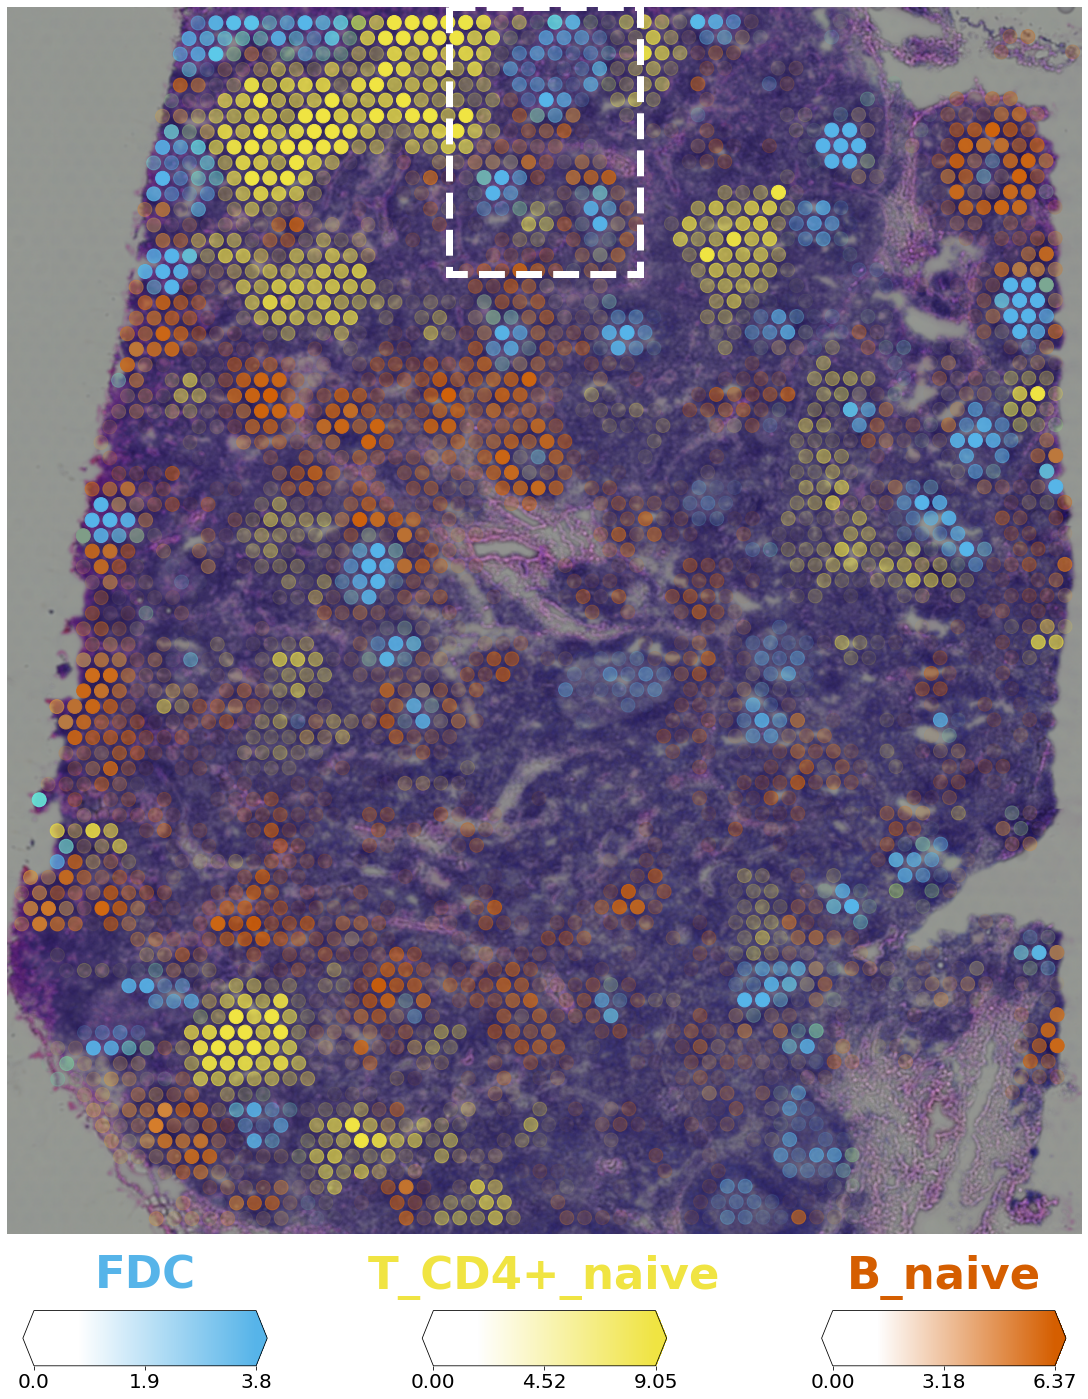

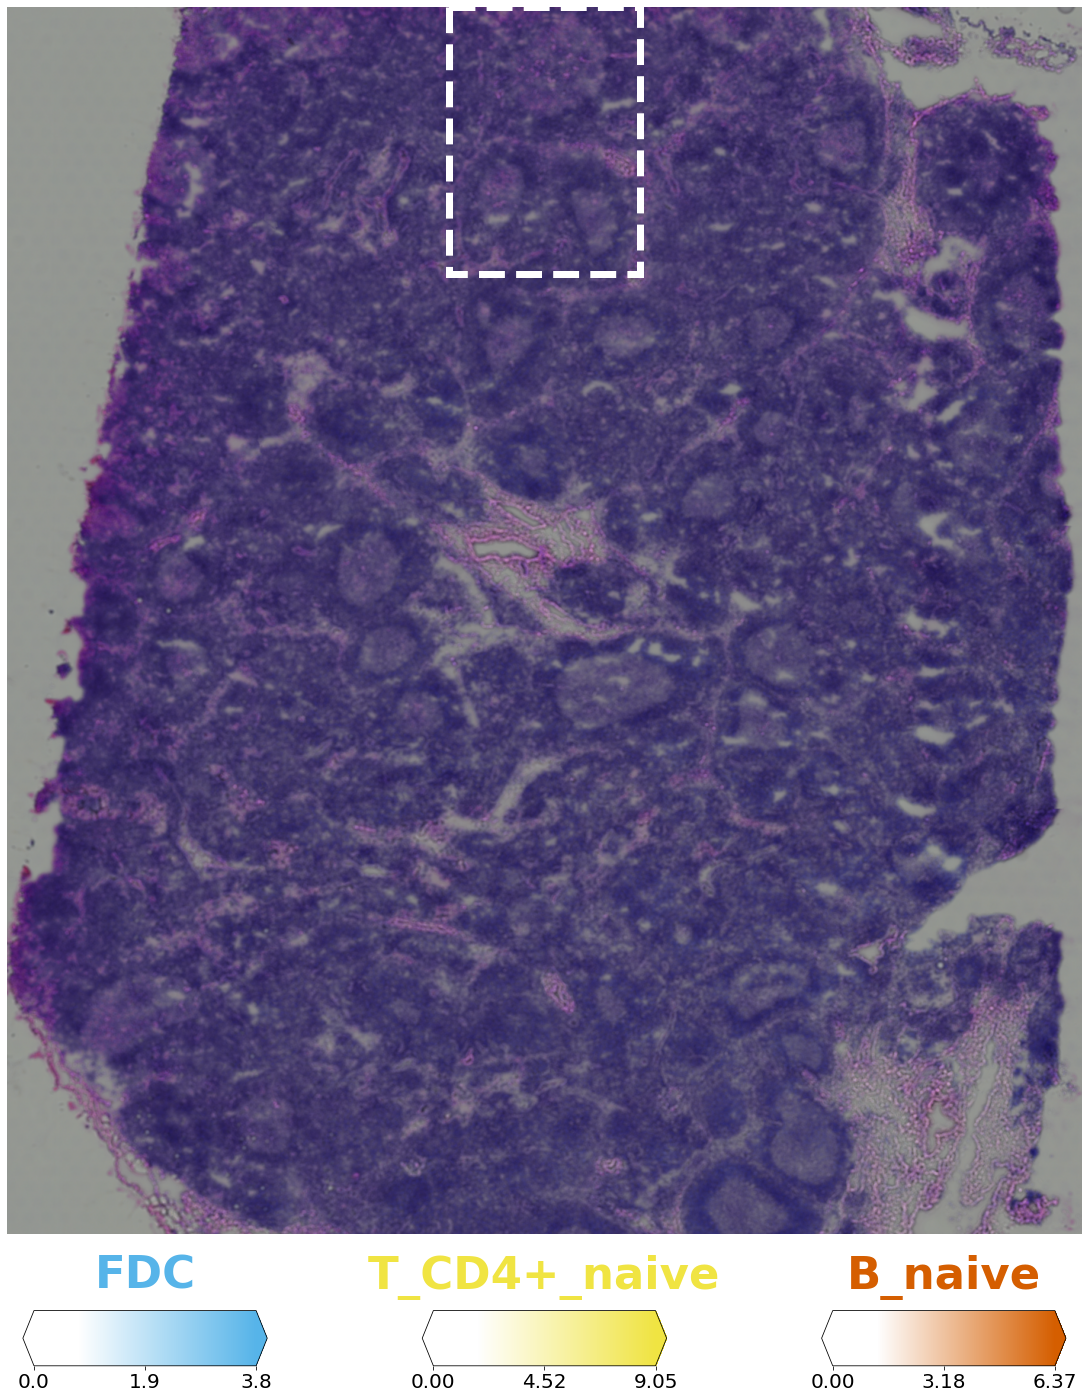

In [5]:
rcParams["axes.facecolor"] = "white"

from cell2location.plt.mapping_video import plot_spatial
# select up to 6 clusters 
sel_clust = ['FDC', 'T_CD4+_naive', 'B_naive']
sel_clust_col = ['' + str(i) for i in sel_clust]

crop_x = [230, 1640]
crop_y = [1760, 150]
crop_x_small = [810, 1060]
crop_y_small = list(adata_vis.uns['spatial'].values())[0]['images']['hires'].shape[0] - np.array([1500, 1850])

rcParams["figure.figsize"] = [25,25]
fig = plot_spatial(adata_vis.obs[sel_clust_col], labels=sel_clust,
              coords=adata_vis.obsm['spatial'] * list(adata_vis.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef'], 
              img=list(adata_vis.uns['spatial'].values())[0]['images']['hires'], show_img=True, img_alpha=1,
              circle_diameter=14, alpha_scaling=1, reorder_cmap=[2, 0, 1],
              max_color_quantile=0.99,
              crop_x=crop_x, crop_y=crop_y, axis_y_flipped=False,
                 colorbar_label_kw={'size': 45, 'weight': 'bold', 'y': 1.29},
                 colorbar_shape={'vertical_gaps': 0.12, 'horizontal_gaps': 1, 
                                 'width': 3.5, 'height': 0.045},
                 colorbar_tick_size=20)
add_rectangle_to_fig(fig, crop_coord=list(crop_x_small) + list(crop_y_small),
                     edgecolor='white', linestyle='--', linewidth=7)
fig.savefig(f'{fig_path}Fig4C_maps.pdf',
                bbox_inches='tight', facecolor='white')

fig = plot_spatial(adata_vis.obs[sel_clust_col], labels=sel_clust,
              coords=adata_vis.obsm['spatial'] * list(adata_vis.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef'], 
              img=list(adata_vis.uns['spatial'].values())[0]['images']['hires'], show_img=True, img_alpha=1,
              circle_diameter=14, alpha_scaling=0, reorder_cmap=[2, 0, 1],
              max_color_quantile=0.99,
              crop_x=crop_x, crop_y=crop_y, axis_y_flipped=False,
                 colorbar_label_kw={'size': 45, 'weight': 'bold', 'y': 1.29},
                 colorbar_shape={'vertical_gaps': 0.12, 'horizontal_gaps': 1, 
                                 'width': 3.5, 'height': 0.045},
                 colorbar_tick_size=20)
add_rectangle_to_fig(fig, crop_coord=list(crop_x_small) + list(crop_y_small),
                     edgecolor='white', linestyle='--', linewidth=7)
fig.savefig(f'{fig_path}Fig4C_histology.pdf',
                bbox_inches='tight', facecolor='white')

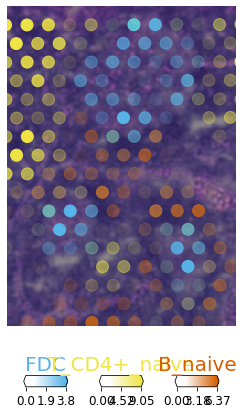

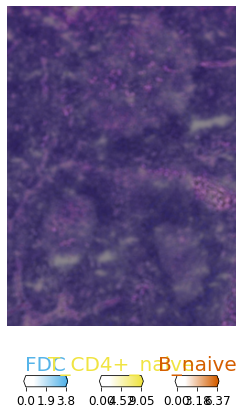

In [6]:
crop_x = [810, 1060]
crop_y = list(adata_vis.uns['spatial'].values())[0]['images']['hires'].shape[0] - np.array([1500, 1850])

rcParams["figure.figsize"] = [7, 7]
fig = plot_spatial(adata_vis.obs[sel_clust_col], labels=sel_clust,
              coords=adata_vis.obsm['spatial'] * list(adata_vis.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef'], 
              img=list(adata_vis.uns['spatial'].values())[0]['images']['hires'], show_img=True, img_alpha=1,
              circle_diameter=12, alpha_scaling=1, reorder_cmap=[2, 0, 1],
              max_color_quantile=0.99,
              crop_x=crop_x, crop_y=crop_y, axis_y_flipped=False)
fig.savefig(f'{fig_path}Fig4C_maps_zoom_in.pdf',
            bbox_inches='tight', facecolor='white')

fig = plot_spatial(adata_vis.obs[sel_clust_col], labels=sel_clust,
              coords=adata_vis.obsm['spatial'] * list(adata_vis.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef'], 
              img=list(adata_vis.uns['spatial'].values())[0]['images']['hires'], show_img=True, img_alpha=1,
              circle_diameter=12, alpha_scaling=0, reorder_cmap=[2, 0, 1],
              max_color_quantile=0.99,
              crop_x=crop_x, crop_y=crop_y, axis_y_flipped=False)
fig.savefig(f'{fig_path}Fig4C_maps_zoom_in_histology.pdf',
            bbox_inches='tight', facecolor='white')

### Fig 4F - B IFN+ & co-located cells <a class="anchor" id="Fig4F"></a>

... storing 'sample' as categorical


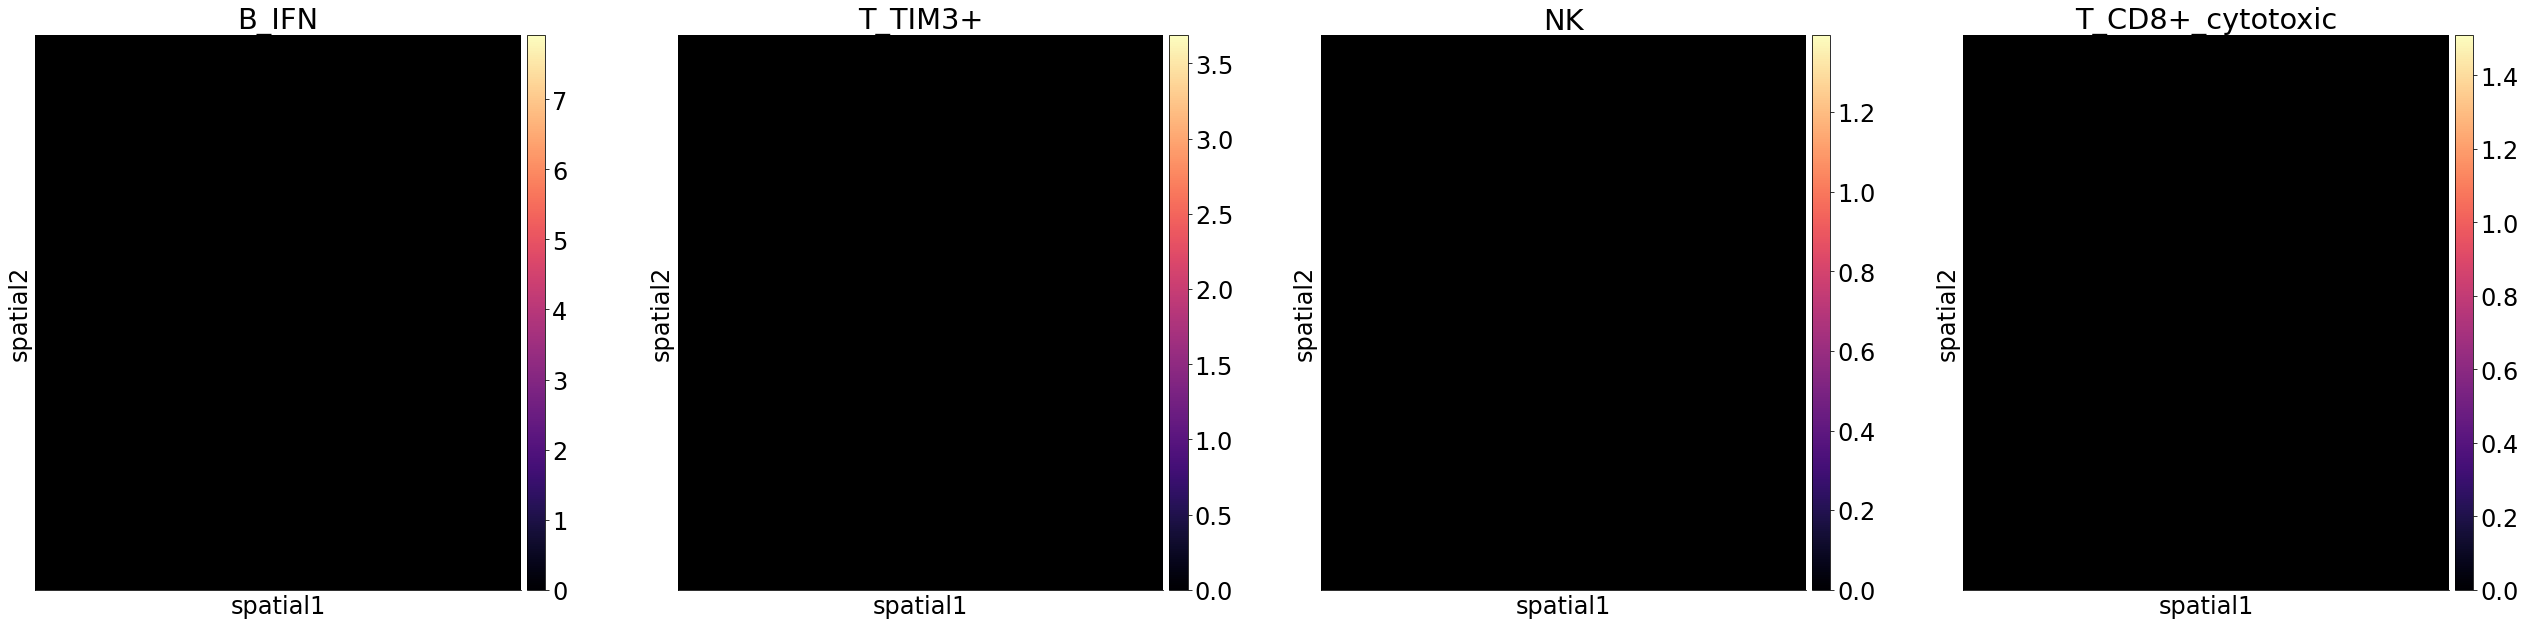

AttributeError: 'list' object has no attribute 'axes'

In [7]:
# Visualize cell type locations
# making copy to transform to log & assign nice names
adata_vis_pl = adata_vis.copy()
#clust_names_orig = ['' + i for i in adata_vis.uns['mod']['fact_names']]
#clust_names = adata_vis.uns['mod']['fact_names']
#adata_vis_pl.obs[clust_names] = (adata_vis_pl.obs[clust_names_orig])

rcParams["axes.facecolor"] = "black"
rcParams["savefig.facecolor"] = "white"
rcParams["figure.figsize"] = [10,10]
rcParams["font.size"] = 24

crop_x = [230, 1640]
crop_y = [150, 1760]

max_y = list(adata_vis_pl.uns['spatial'].values())[0]['images']['hires'].shape[1]
crop_y = [max_y - i + 80 for i in crop_y]
img_shape = list(adata_vis.uns['spatial'].values())[0]['images']['hires'].shape

ct_list=['B_IFN', 'T_TIM3+', 'NK', 'T_CD8+_cytotoxic']

fig = sc.pl.spatial(adata_vis_pl, cmap='magma',
              color=ct_list, ncols=4, 
              size=1.3, img_key='hires', alpha_img=0,
              frameon=True, legend_fontsize=50,
              crop_coord=crop_x + [crop_y[0]] + [crop_y[1]],
              vmin=0, vmax='p99.5', 
              return_fig=True, save='Fig_4F.pdf'
             )
add_rectangle_to_fig(fig, [960, 1430, 
                           img_shape[1] - 1670 + (img_shape[1] - crop_y[0]), 
                           img_shape[1] - 1370 + (img_shape[1] - crop_y[0])],
                     edgecolor='white', linestyle='--', linewidth=5)
fig.savefig(f'{fig_path}Fig_4F.pdf',
            bbox_inches='tight', facecolor='white')

rcParams["figure.figsize"] = [13.5,6]
sc.pl.spatial(adata_vis_pl, cmap='magma',
              color=ct_list, ncols=4, 
              size=1.3, img_key='hires', alpha_img=0,
              frameon=True, legend_fontsize=50,
              #crop_coord=crop_x + [crop_y[0]] + [crop_y[1]],
              vmin=0, vmax='p99.5', save=f'Fig_4F_cropped.pdf',
              crop_coord=[960, 1430, 1670, 1370]
             )

### Fig 4G - binned B_IFN abundance dotplot <a class="anchor" id="Fig4G"></a>

Trying to set attribute `.obs` of view, copying.
/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/cell2location/plt/plot_heatmap.py:114: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


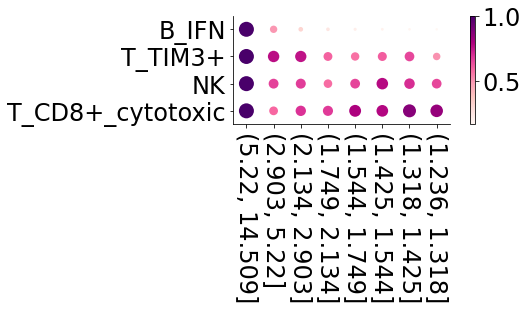

In [8]:
adata_vis_dpt = adata_vis.copy()

col_name = 'B_IFN'
# order adata object by B_IFN abundance
adata_vis_dpt = adata_vis_dpt[adata_vis_dpt.obs[col_name].sort_values(ascending=False).index, :]

adata_vis_dpt.obs[f'{col_name}_bin'] = pd.qcut(adata_vis_dpt.obs[col_name], 
                                               #q=[0.07, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0], 
                                               q=75,
                                               precision=int(2))
#adata_vis_dpt.obs[f'{col_name}_bin'] = pd.cut(adata_vis_dpt.obs[col_name], 
#                                               bins=10,
#                                               precision=int(1))
bin_order = adata_vis_dpt.obs[f'{col_name}_bin'].cat.categories
adata_vis_dpt.obs[f'{col_name}_bin'] = adata_vis_dpt.obs[f'{col_name}_bin'].astype('str')

# Compute average abundance of each region cluster
from cell2location.cluster_averages.cluster_averages import get_cluster_averages_df
from cell2location.plt.plot_heatmap import clustermap

ct_aver = get_cluster_averages_df(X=adata_vis_dpt.obs[['' + i 
                                                      for i in adata_vis_dpt.uns['mod']['factor_names']]],
                                  cluster_col=adata_vis_dpt.obs[f"{col_name}_bin"])
ct_aver.index = adata_vis_dpt.uns['mod']['factor_names']
ct_aver = ct_aver.loc[ct_list, :]

# normalise to get % of each cell type in each location
ct_aver = (ct_aver.T / ct_aver.max(1)).T
ct_aver = ct_aver[[str(i) for i in bin_order][::-1][0:8][::-1]]

with matplotlib.rc_context({'axes.facecolor':  'white'}):
    clustermap(ct_aver, fun_type='dotplot',
               cluster_rows=False, cluster_cols=False, figure_size=(7, 2))
    plt.savefig(f'{str(sc.settings.figdir)}/Fig_4G_diffmap_dotplot.pdf',
                bbox_inches='tight', facecolor='white')

Trying to set attribute `.obs` of view, copying.


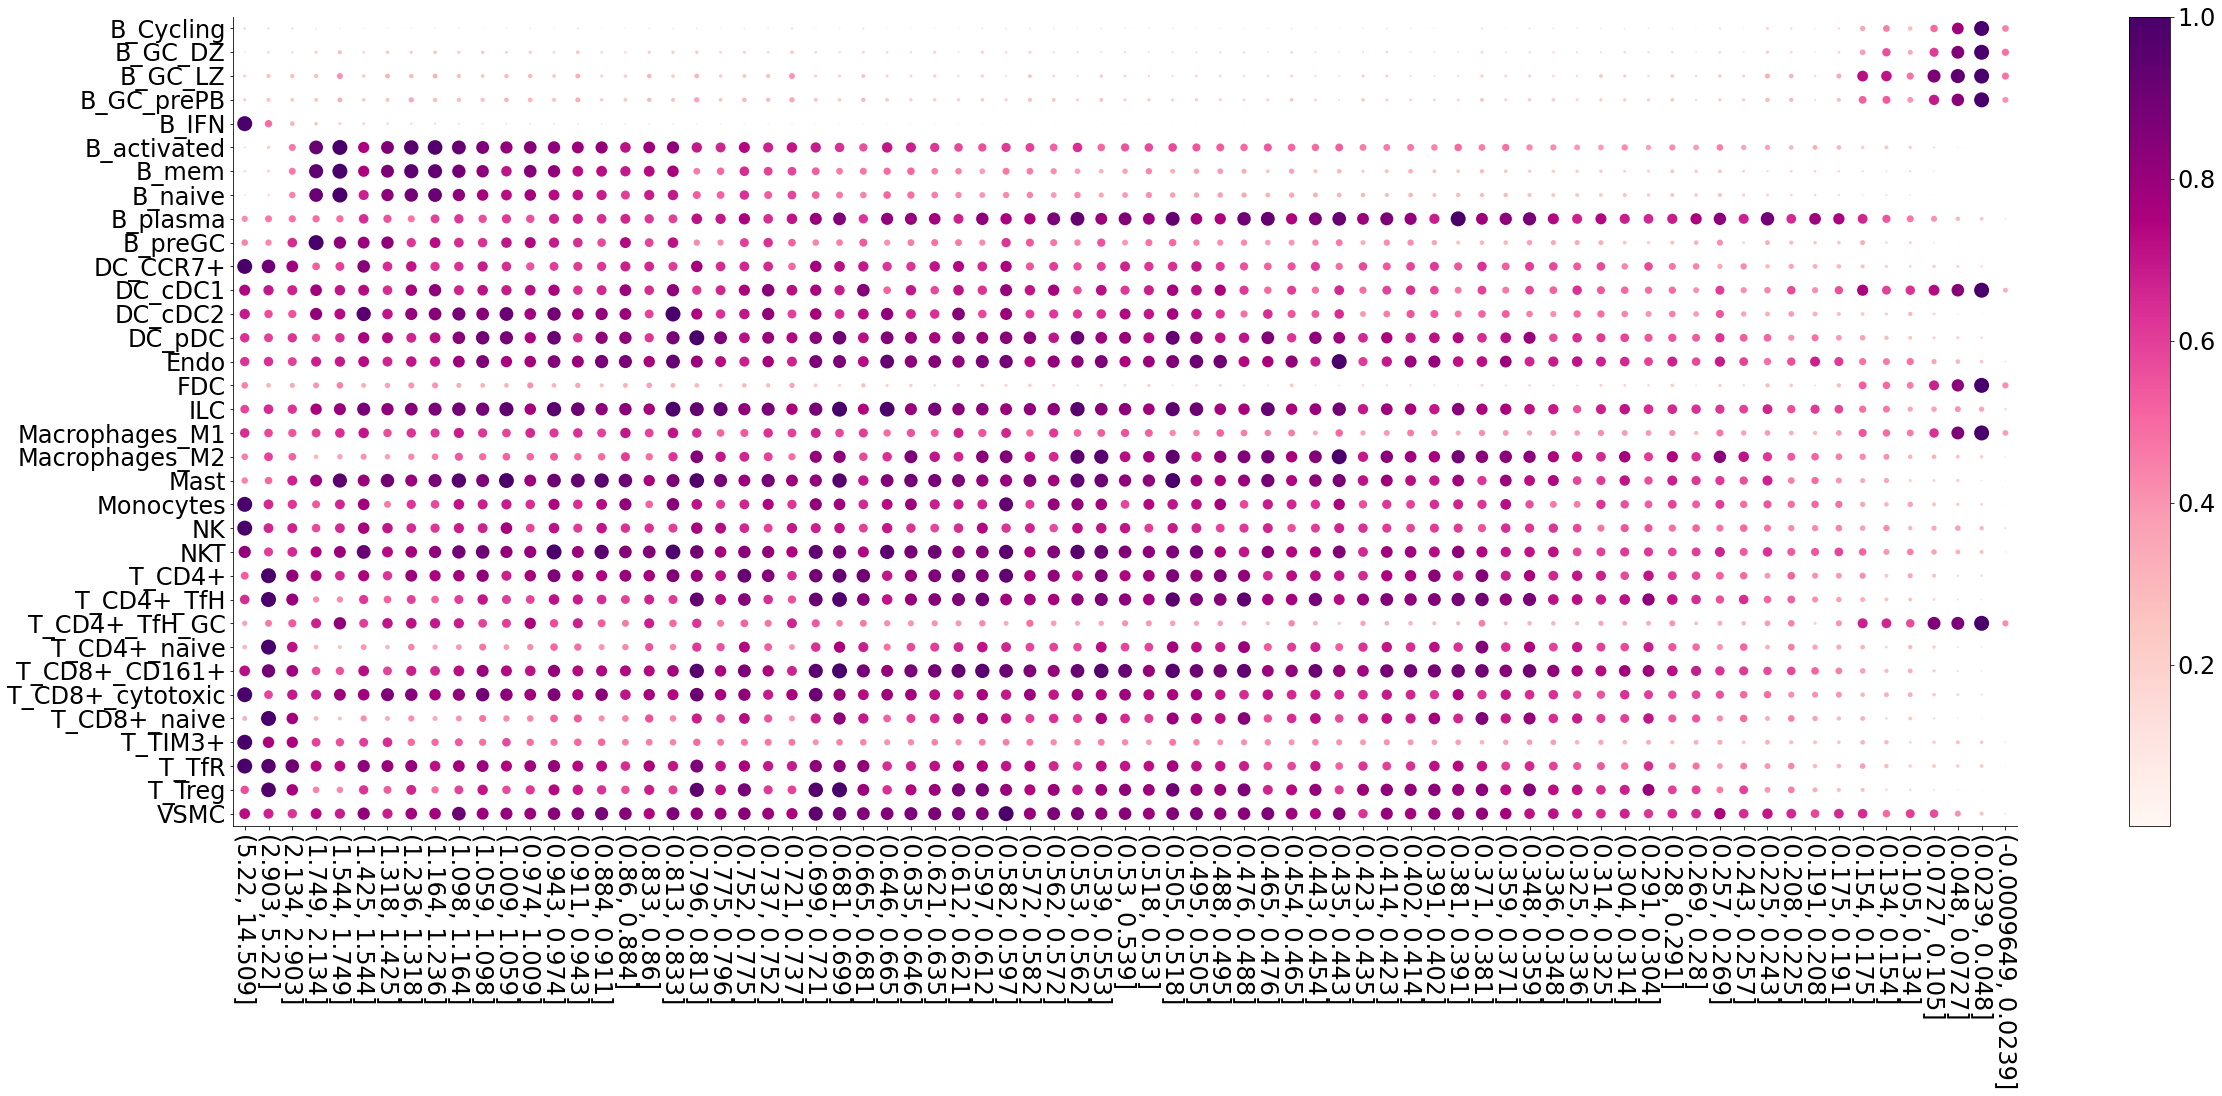

In [9]:
adata_vis_dpt = adata_vis.copy()

col_name = 'B_IFN'
# order adata object by B_IFN abundance
adata_vis_dpt = adata_vis_dpt[adata_vis_dpt.obs[col_name].sort_values(ascending=False).index, :]

adata_vis_dpt.obs[f'{col_name}_bin'] = pd.qcut(adata_vis_dpt.obs[col_name], 
                                               #q=[0.07, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0], 
                                               q=75,
                                               precision=int(2))
#adata_vis_dpt.obs[f'{col_name}_bin'] = pd.cut(adata_vis_dpt.obs[col_name], 
#                                               bins=10,
#                                               precision=int(1))
bin_order = adata_vis_dpt.obs[f'{col_name}_bin'].cat.categories
adata_vis_dpt.obs[f'{col_name}_bin'] = adata_vis_dpt.obs[f'{col_name}_bin'].astype('str')

# Compute average abundance of each region cluster
from cell2location.cluster_averages.cluster_averages import get_cluster_averages_df
from cell2location.plt.plot_heatmap import clustermap

ct_aver = get_cluster_averages_df(X=adata_vis_dpt.obs[['' + i 
                                                      for i in adata_vis_dpt.uns['mod']['factor_names']]],
                                  cluster_col=adata_vis_dpt.obs[f"{col_name}_bin"])
ct_aver.index = adata_vis_dpt.uns['mod']['factor_names']
ct_aver = ct_aver[[str(i) for i in bin_order]]

# normalise to get % of each cell type in each location
ct_aver = (ct_aver.T / ct_aver.max(1)).T
with matplotlib.rc_context({'axes.facecolor':  'white'}):
    clustermap(ct_aver, fun_type='dotplot',
               cluster_rows=False, cluster_cols=False, figure_size=(35, 15))
    plt.savefig(f'{str(sc.settings.figdir)}/Fig_4G_diffmap_dotplot_full.pdf',
                bbox_inches='tight', facecolor='white')

### Read saved sklearn colocated cell group model <a class="anchor" id="read_nmf"></a>

In [10]:
# import models
def unpickle_model(path, mod_name):
    r""" Unpickle model
    """
    file = path + 'model_' + mod_name + ".p"
    
    mod1_ann = pickle.load(file = open(file, "rb"))
    return mod1_ann['mod']

n_fact = 12
mod_path = f'{scvi_run_path}/CoLocatedComb/CoLocatedGroupsSklearnNMF_4035locations_34factorstol0.0001/models/' 
adata_file = f'{scvi_run_path}/CoLocatedComb/CoLocatedGroupsSklearnNMF_4035locations_34factorstol0.0001/anndata/sp.h5ad' 


mod_sk = unpickle_model(mod_path, f'n_fact{n_fact}')

adata_vis_sk = anndata.read(adata_file)

### Fig 4D - co-located cell groups - dotplot <a class="anchor" id="Fig4D_dotplot"></a>

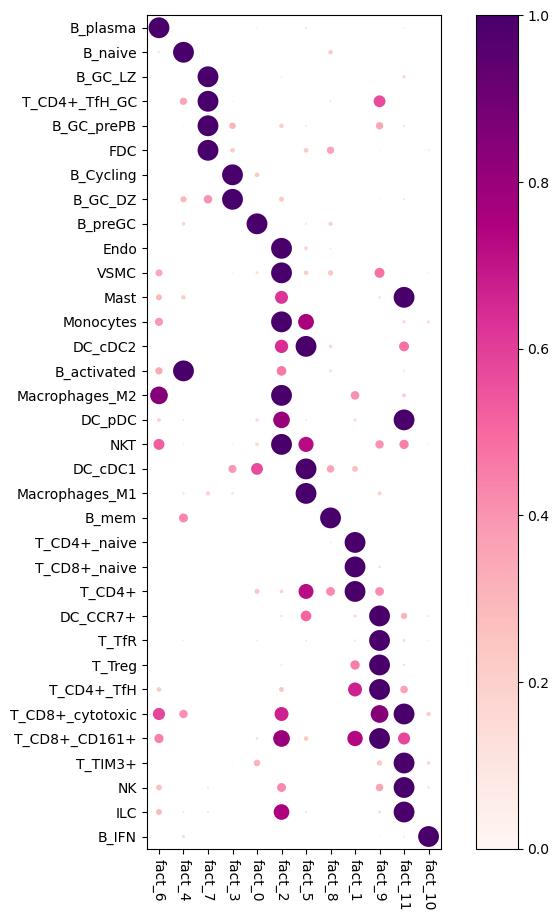

In [11]:
b_dev_sel = ['B_plasma', 'B_naive',
             
             'B_GC_LZ', 'T_CD4+_TfH_GC', 'B_GC_prePB', 'FDC', 
             'B_Cycling', 'B_GC_DZ',
             
             'B_preGC',
             'Endo', 'VSMC', 'Mast', 'Monocytes', 'DC_cDC2', 'B_activated', 'Macrophages_M2', 'DC_pDC', 'NKT', 
             'DC_cDC1', 'Macrophages_M1', 
             
             'B_mem',
             
             'T_CD4+_naive', 'T_CD8+_naive', 'T_CD4+', 
             
             'DC_CCR7+', 'T_TfR', 'T_Treg', 'T_CD4+_TfH', 'T_CD8+_cytotoxic', 'T_CD8+_CD161+',  
             
             'T_TIM3+', 'NK', 'ILC', 
             'B_IFN', 
            ]

fact_filt = ['fact_6', 'fact_4', 
             'fact_7', 'fact_3', 
             'fact_0', 'fact_2', 'fact_5', 
             
             'fact_8', 
             
             'fact_1', 'fact_9',
             'fact_11', 'fact_10']

mod_sk.cell_type_fractions = (mod_sk.cell_type_fractions.T / mod_sk.cell_type_fractions.max(1)).T

matplotlib.rc_file_defaults()
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
clustermap(mod_sk.cell_type_fractions.loc[b_dev_sel, fact_filt[::-1]],
           cluster_rows=False, cluster_cols=False, 
           figure_size=[5.9 + 0.12 * mod_sk.n_fact, 5.9 + 0.1 * mod_sk.n_var],
           fun_type='dotplot', array_size=None)

plt.savefig(f'{fig_path}/Fig4D_fact_dotplot.pdf', bbox_inches='tight')
plt.show()

### Fig 4D - Supplementary - matching clustering - dotplot <a class="anchor" id="Fig4D_suppl_clust"></a>

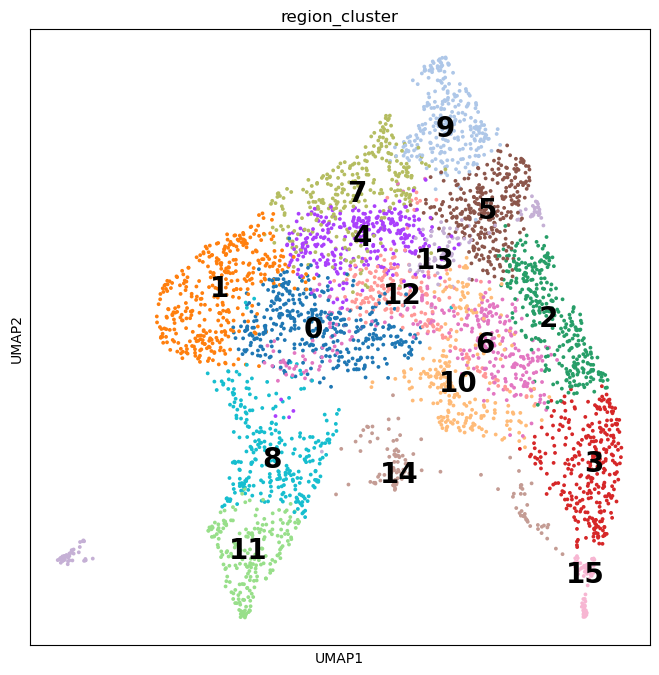

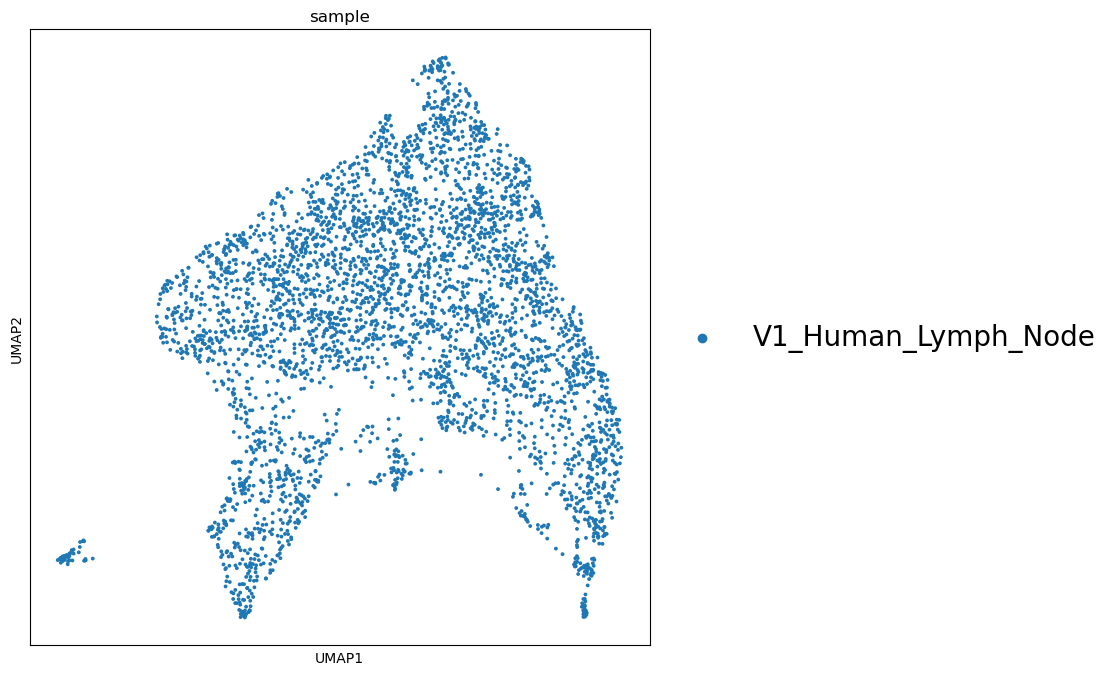

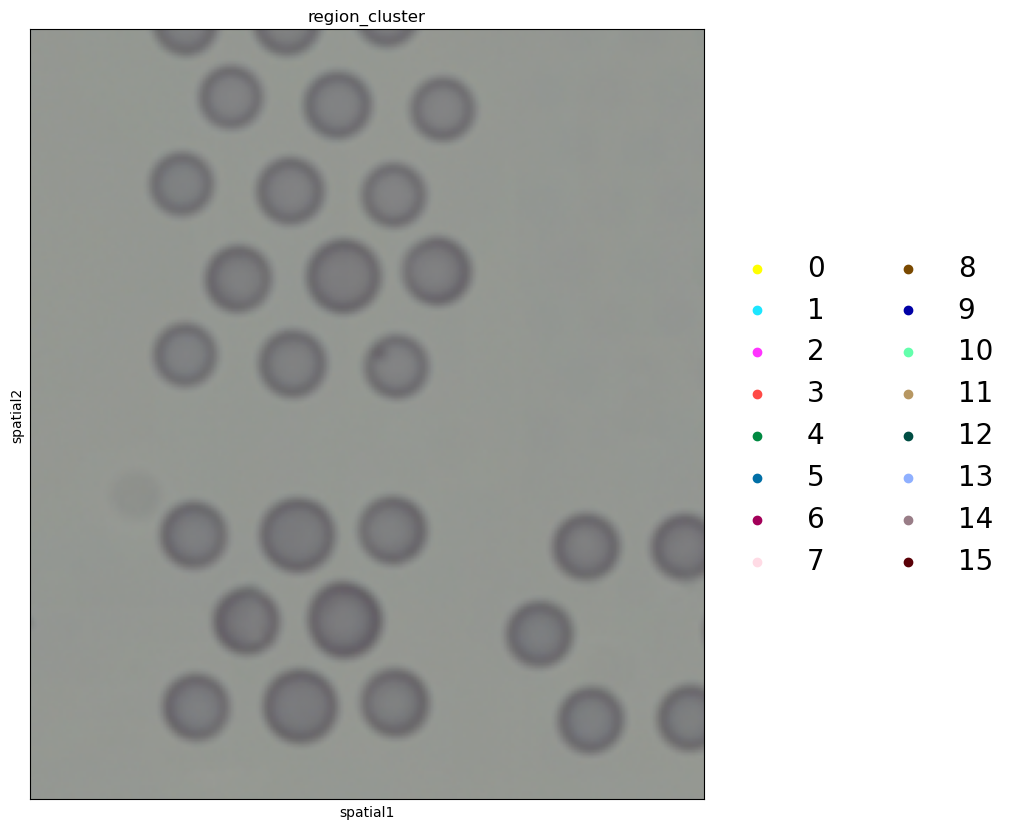

In [16]:
# compute KNN using the cell2location output stored in adata.obsm
sc.pp.neighbors(adata_vis_sk, use_rep='q05_cell_abundance_w_sf',
                n_neighbors = 15)

# Repeat clustering of regions to get matching number
# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis_sk, resolution=1)

# add region as categorical variable
adata_vis_sk.obs["region_cluster"] = adata_vis_sk.obs["leiden"].astype("category")

# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(adata_vis_sk, min_dist = 0.3, spread = 1)

# show regions in UMAP coordinates
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [8, 8]}):
    sc.pl.umap(adata_vis_sk, color=['region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20)
    sc.pl.umap(adata_vis_sk, color=['sample'], size=30,
               color_map = 'RdPu', ncols = 2,
               legend_fontsize=20)

# plot in spatial coordinates
crop_x = [230, 1640]
crop_y = [150, 1760]

max_y = list(adata_vis_sk.uns['spatial'].values())[0]['images']['hires'].shape[1]
crop_y = [max_y - i + 80 for i in crop_y]

with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [10, 10]}):
    sc.pl.spatial(adata_vis_sk, cmap='magma',
                  color=['region_cluster'], ncols=4, 
                  size=1.3, img_key='hires', alpha_img=1,
                  frameon=True, legend_fontsize=20,
                  crop_coord=crop_x + [crop_y[0]] + [crop_y[1]],
                  vmin=0, vmax='p99.5', save='Fig4D_suppl_spatial_clusters.pdf',
                  palette=sc.pl.palettes.default_102
                 )

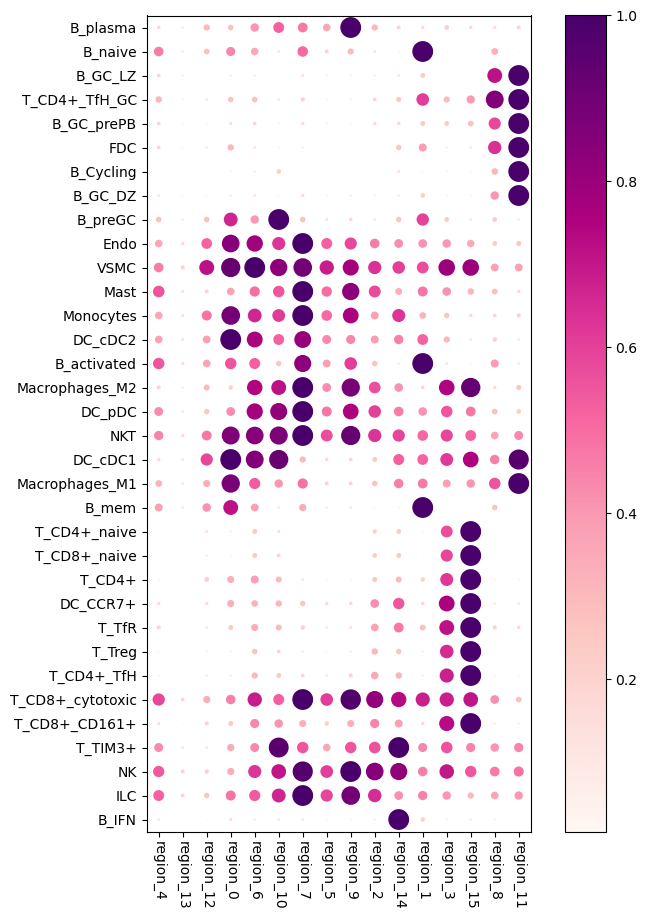

In [18]:
# Compute average abundance of each region cluster
from cell2location.cluster_averages.cluster_averages import get_cluster_averages_df
from cell2location.plt.plot_heatmap import clustermap
#plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
#plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False

ct_aver = get_cluster_averages_df(X=adata_vis_sk.obs[['' + i 
                                                      for i in adata_vis_sk.uns['mod']['factor_names']]],
                        cluster_col=adata_vis_sk.obs["region_cluster"])
ct_aver.index = adata_vis_sk.uns['mod']['fact_names']
ct_aver.columns = ['region_' + c for c in ct_aver.columns]

# normalise to get 10% of each cell type in each location
ct_aver = (ct_aver.T / ct_aver.max(1)).T

matplotlib.rc_file_defaults()
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
clustermap(ct_aver.loc[b_dev_sel, :],
           cluster_rows=False, cluster_cols=True, 
           figure_size=[5.9 + 0.12 * mod_sk.n_fact, 5.9 + 0.1 * mod_sk.n_var],
           fun_type='dotplot', array_size=None)

plt.savefig(f'{fig_path}/Fig4D_suppl_cluster_dotplot.pdf', bbox_inches='tight')
plt.show()

###  Fig 4D - factor spatial <a class="anchor" id="Fig4D_spatial"></a>

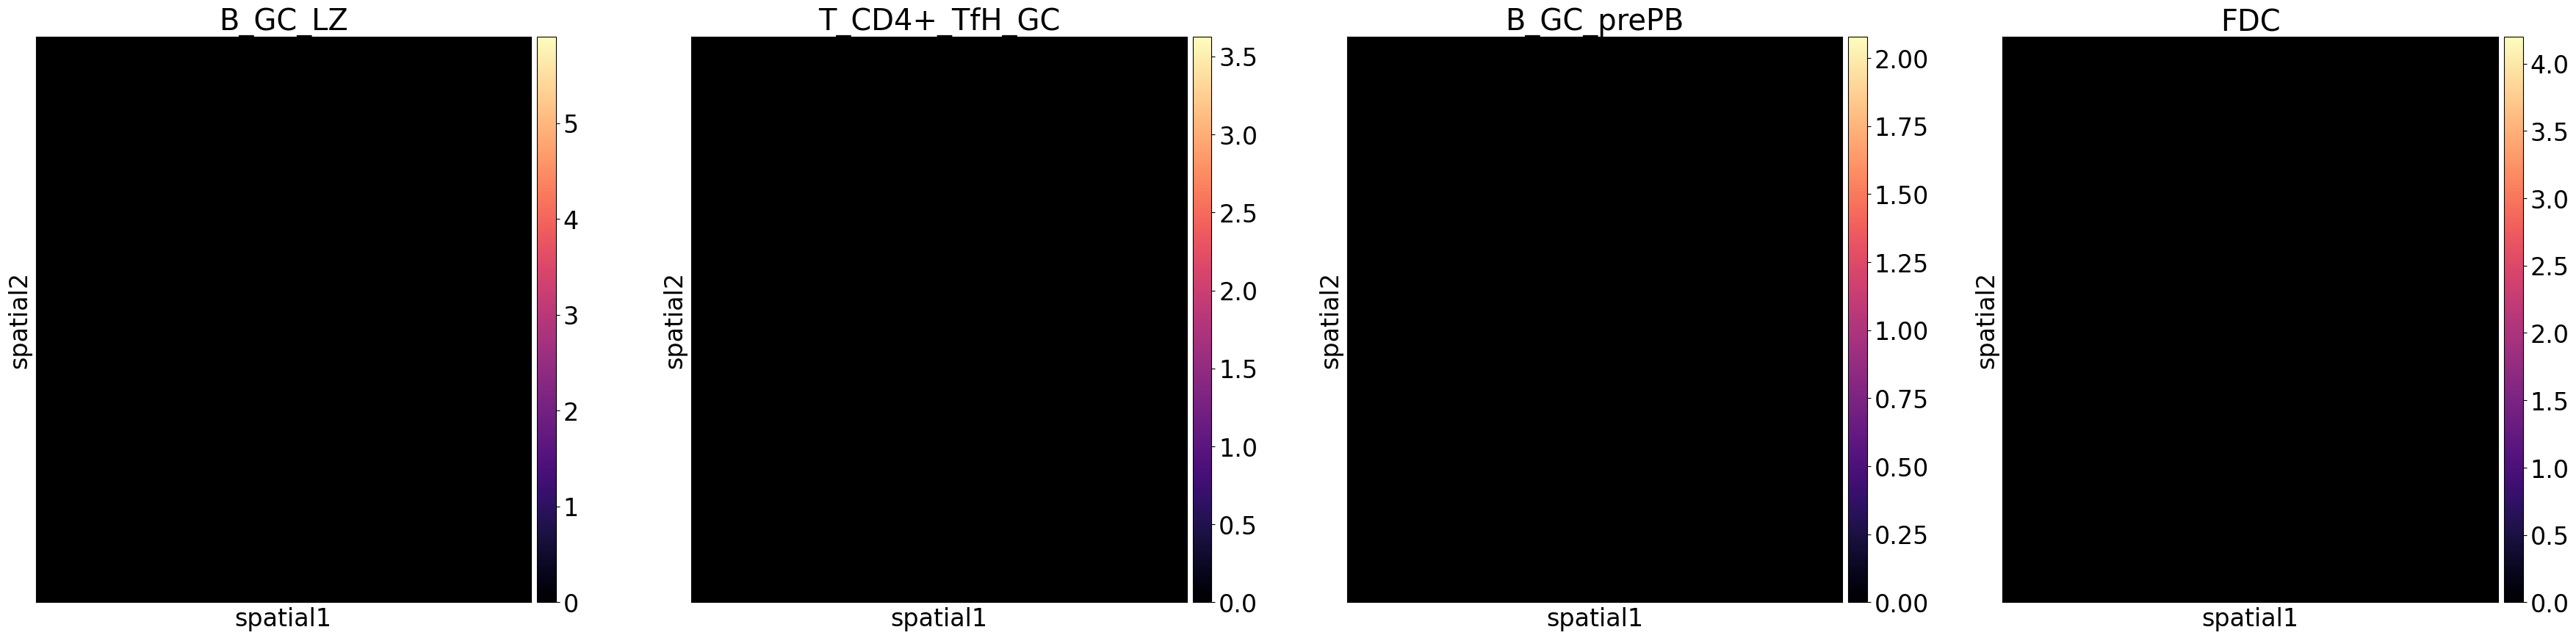

AttributeError: 'list' object has no attribute 'axes'

In [20]:
# Visualize cell type locations
# making copy to transform to log & assign nice names
adata_vis_pl = adata_vis_sk.copy()
clust_names_orig = ['' + i for i in adata_vis_sk.uns['mod']['factor_names']]
clust_names = adata_vis_sk.uns['mod']['factor_names']
adata_vis_pl.obs[clust_names] = (adata_vis_pl.obs[clust_names_orig])

fact_names_orig = ['mean_nUMI_factors' + i for i in adata_vis_sk.uns[f'mod_coloc_n_fact{n_fact}']['fact_names']]
fact_names = adata_vis_sk.uns[f'mod_coloc_n_fact{n_fact}']['fact_names']
adata_vis_pl.obs[fact_names] = pd.DataFrame(adata_vis_sk.uns[f'mod_coloc_n_fact{n_fact}']['post_sample_means']['nUMI_factors'],
                                            index=adata_vis_sk.uns[f'mod_coloc_n_fact{n_fact}']['obs_names'],
                                            columns=fact_names)

rcParams["axes.facecolor"] = "black"
rcParams["savefig.facecolor"] = "white"
rcParams["font.size"] = 24

crop_x = [230, 1640]
crop_y = [150, 1760]

max_y = list(adata_vis_pl.uns['spatial'].values())[0]['images']['hires'].shape[1]
crop_y = [max_y - i + 80 for i in crop_y]

def plot_spatial_factors(adata, ct, crop_coord_small, fig_name=''):
    
    with matplotlib.rc_context({'axes.facecolor':  'black',
                                'savefig.facecolor': 'white',
                                'font.size': 24,
                                'figure.figsize': [10, 10]}):
        
        img_shape = list(adata.uns['spatial'].values())[0]['images']['hires'].shape
        
        fig = sc.pl.spatial(adata, cmap='magma',
                      color=ct, ncols=5, 
                      size=1.3, img_key='hires', alpha_img=0,
                      frameon=True, legend_fontsize=50,
                      crop_coord=crop_x + [crop_y[0]] + [crop_y[1]],
                      vmin=0, vmax='p99.5',
                      return_fig=True
                     )
        add_rectangle_to_fig(fig, [crop_coord_small[0], crop_coord_small[1], 
                                   img_shape[1] - crop_coord_small[2] + (img_shape[1] - crop_y[0]), 
                                   img_shape[1] - crop_coord_small[3] + (img_shape[1] - crop_y[0])],
                             edgecolor='white', linestyle='--', linewidth=5)
        fig.savefig(f'{fig_path}{fig_name}{ct[0]}.pdf',
                    bbox_inches='tight', facecolor='white')

    with matplotlib.rc_context({'axes.facecolor':  'black',
                                'savefig.facecolor': 'white',
                                'font.size': 24,
                                'figure.figsize': [12.5, 10]}):
        
        sc.pl.spatial(adata, cmap='magma',
                      color=ct, ncols=5, 
                      size=1.3, img_key='hires', alpha_img=0,
                      frameon=True, legend_fontsize=50,
                      vmin=0, vmax='p99.5', save=f'{fig_name}{ct[0]}_cropped.pdf',
                      crop_coord=crop_coord_small
                     )


ct_list=['B_GC_LZ', 'T_CD4+_TfH_GC', 'B_GC_prePB', 'FDC']
coord_small = [810, 1200, 1850, 1450]
plot_spatial_factors(adata_vis_pl, ct_list, coord_small, 'Fig4D_fact_3_')

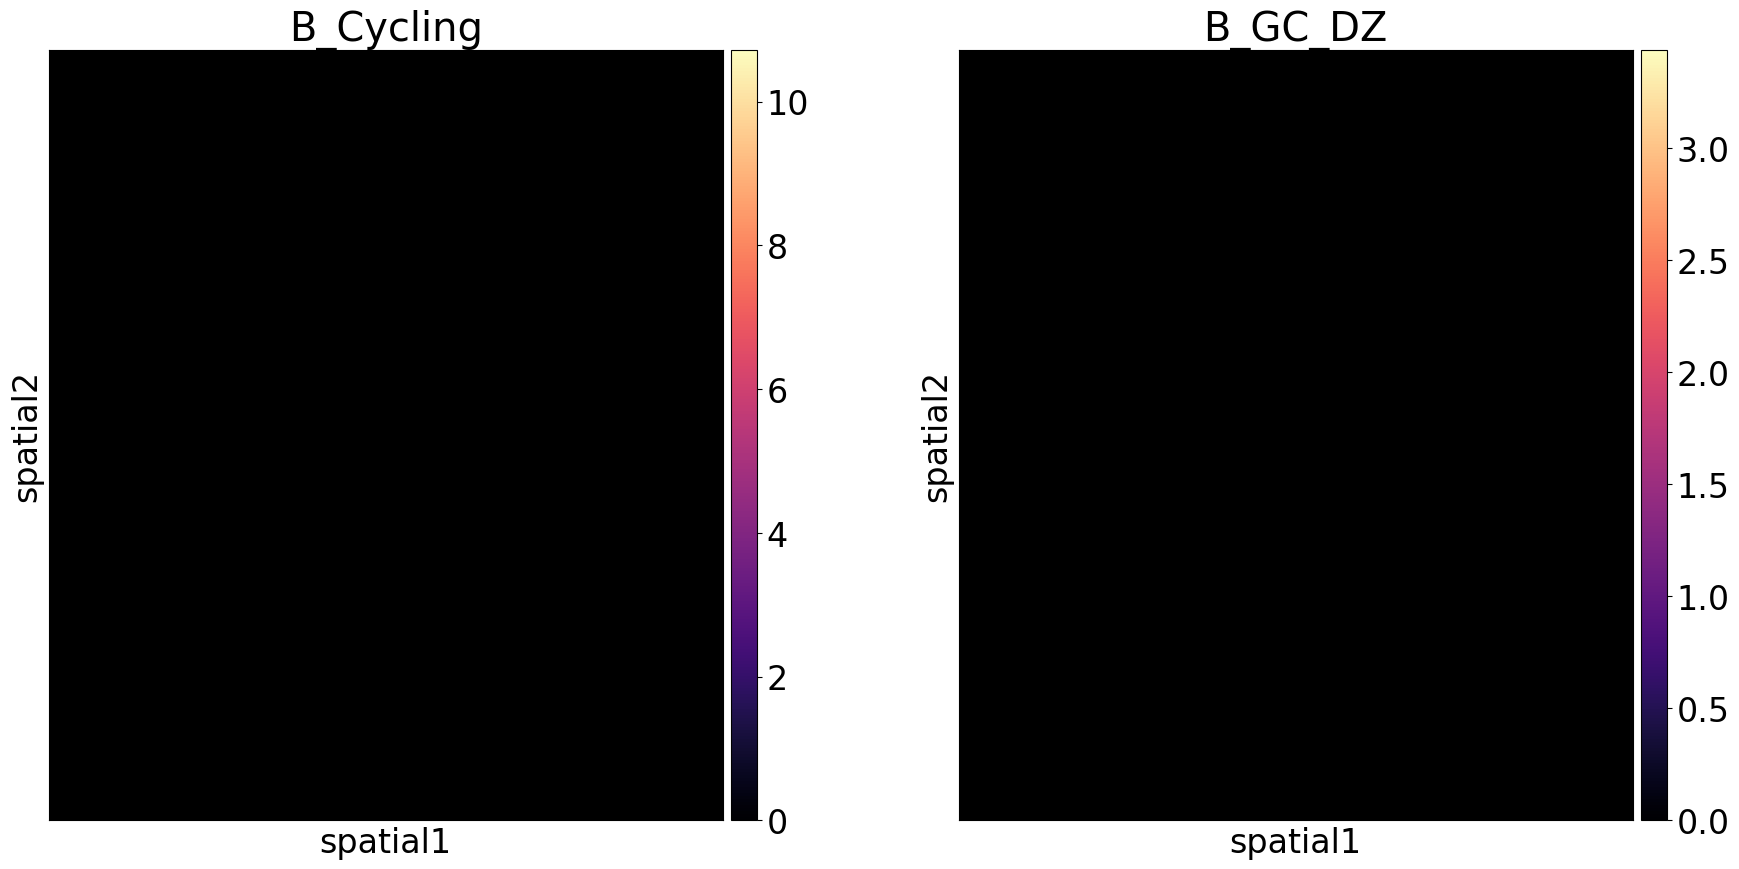

AttributeError: 'list' object has no attribute 'axes'

In [21]:
ct_list=['B_Cycling', 'B_GC_DZ']

plot_spatial_factors(adata_vis_pl, ct_list, coord_small, 'Fig4D_fact_6_')

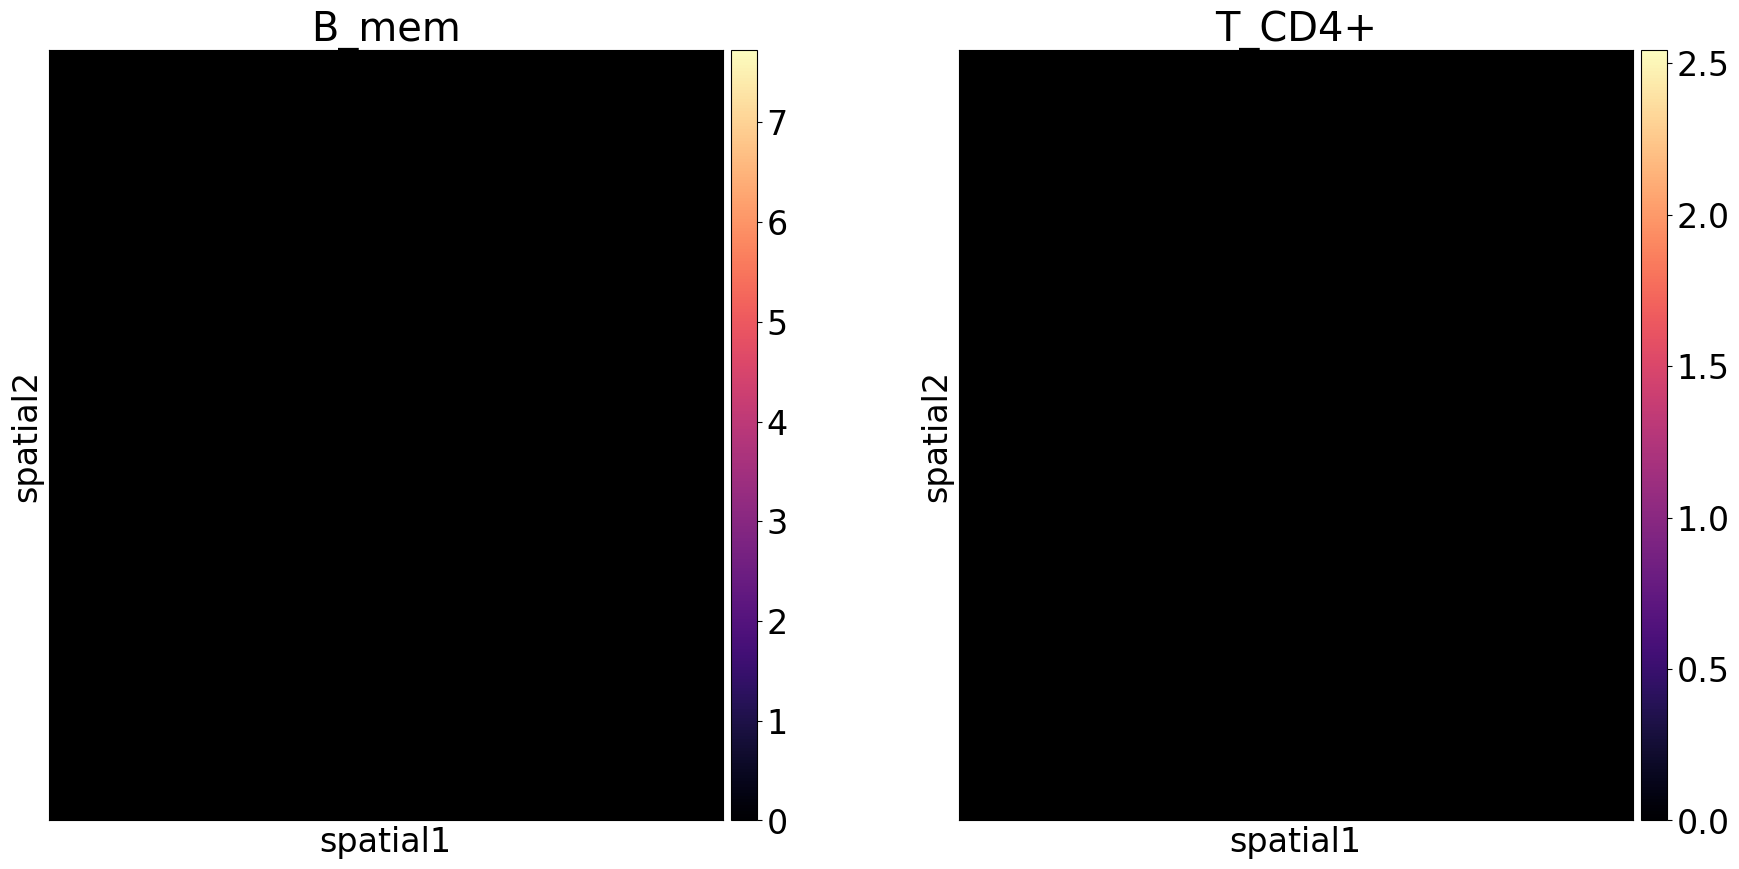

AttributeError: 'list' object has no attribute 'axes'

In [22]:
ct_list=['B_mem', 'T_CD4+']

plot_spatial_factors(adata_vis_pl, ct_list, coord_small, 'Fig4D_fact_9_')

In [ ]:
ct_list=['Endo', 'VSMC', 'Monocytes']

plot_spatial_factors(adata_vis_pl, ct_list, coord_small, 'Fig4D_fact_11_')

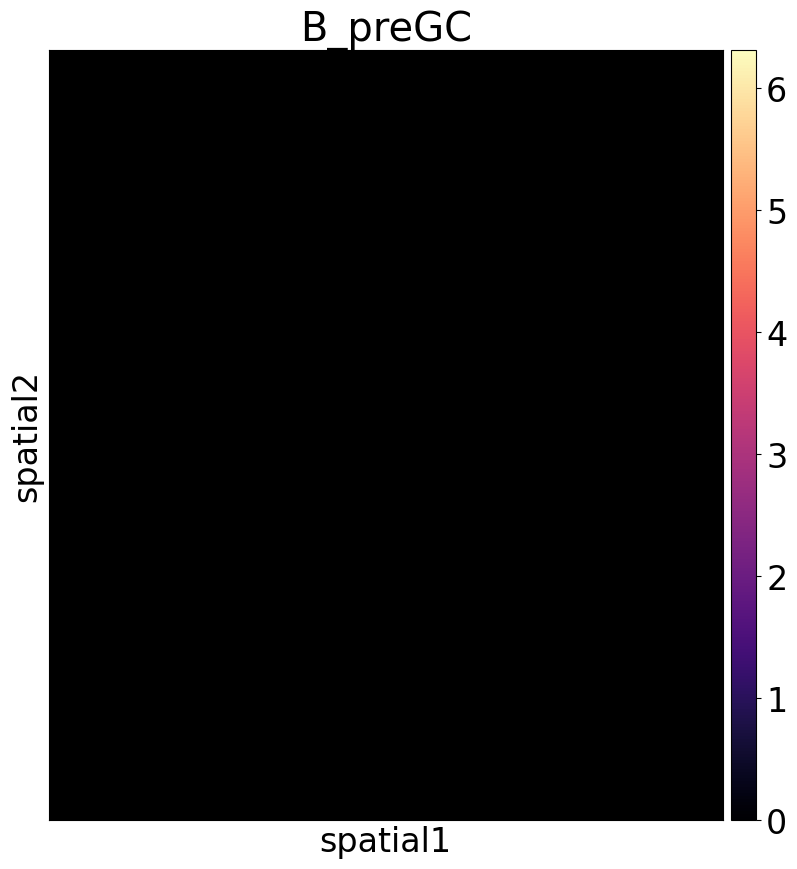

AttributeError: 'list' object has no attribute 'axes'

In [23]:
ct_list=['B_preGC']

plot_spatial_factors(adata_vis_pl, ct_list, coord_small, 'Fig4D_fact_12_')

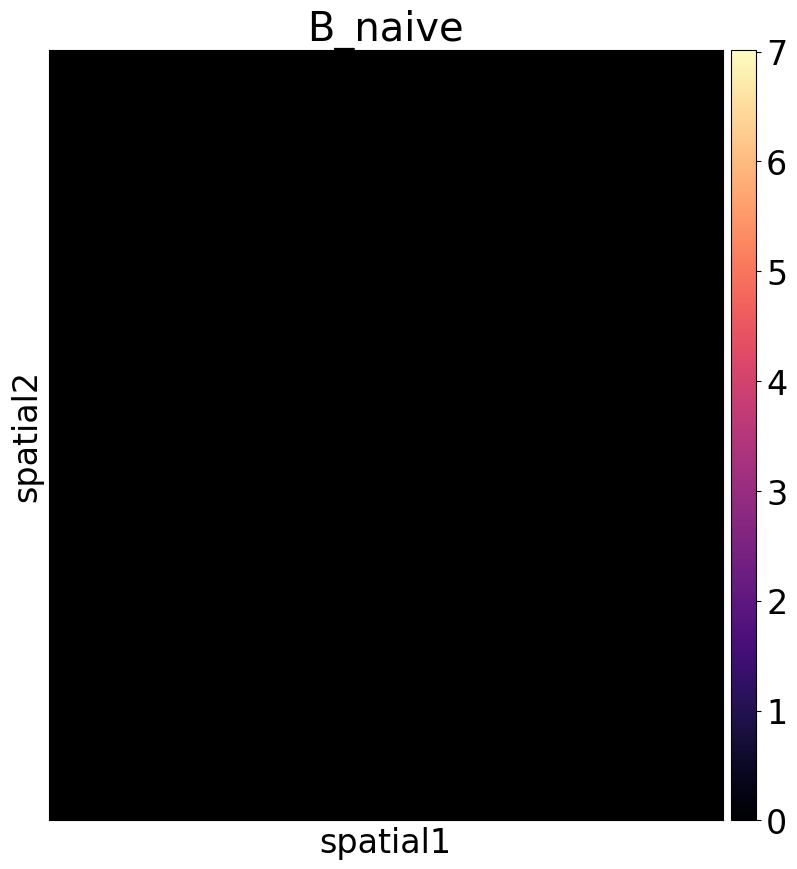

AttributeError: 'list' object has no attribute 'axes'

In [24]:
ct_list=['B_naive']

plot_spatial_factors(adata_vis_pl, ct_list, coord_small, 'Fig4D_fact_4_')

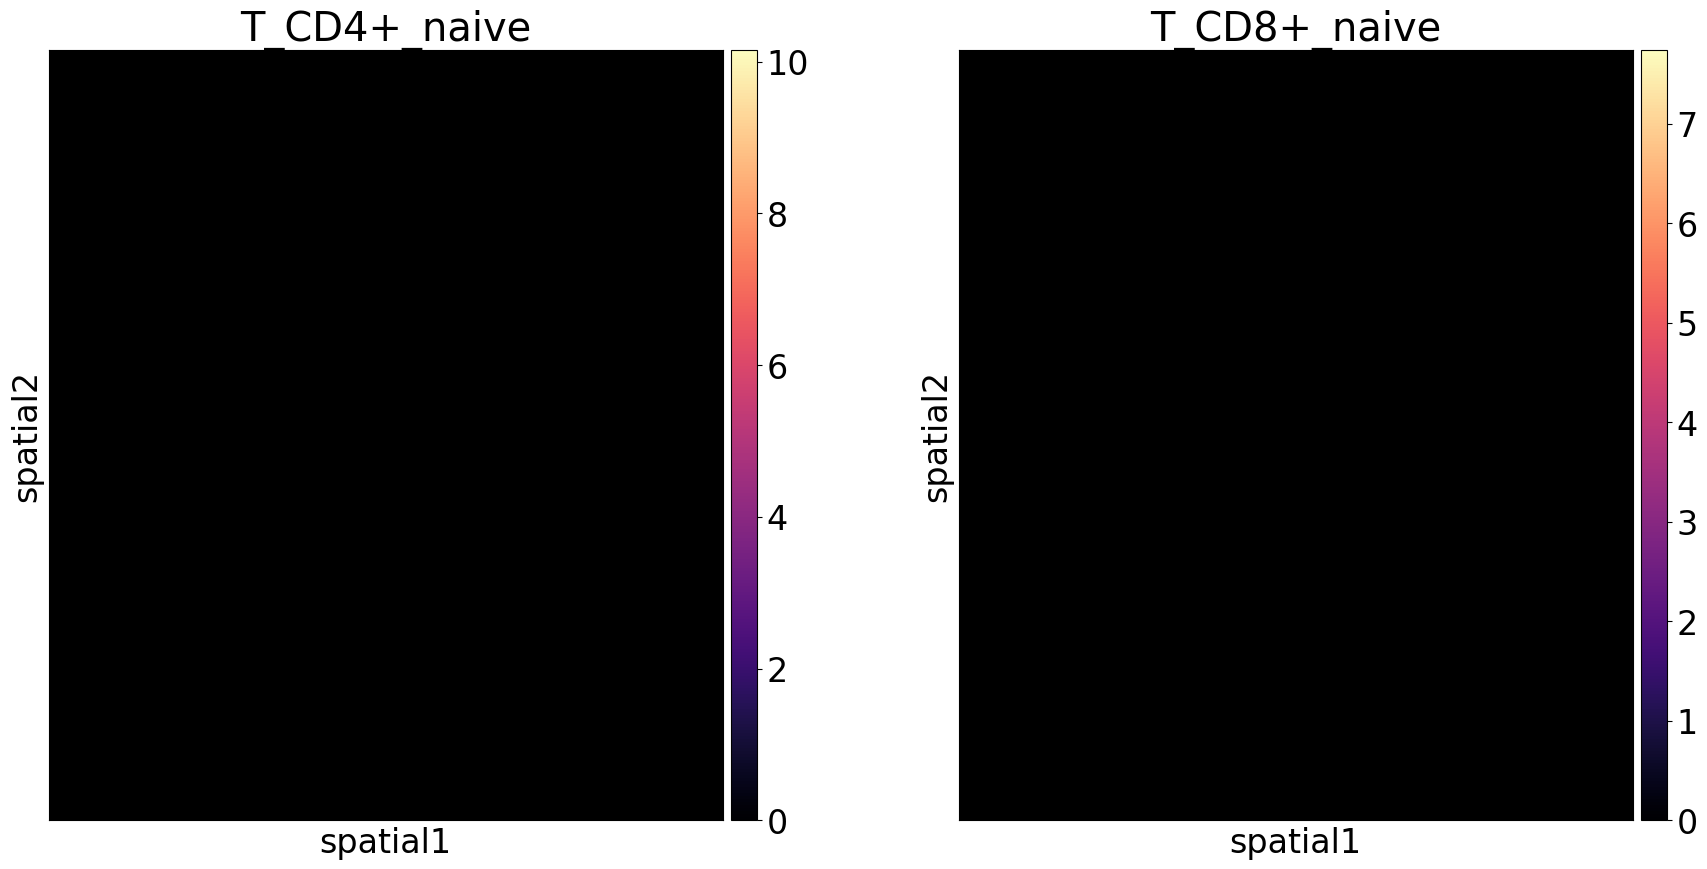

AttributeError: 'list' object has no attribute 'axes'

In [25]:
ct_list=['T_CD4+_naive', 'T_CD8+_naive']

plot_spatial_factors(adata_vis_pl, ct_list, coord_small, 'Fig4D_fact_0_')

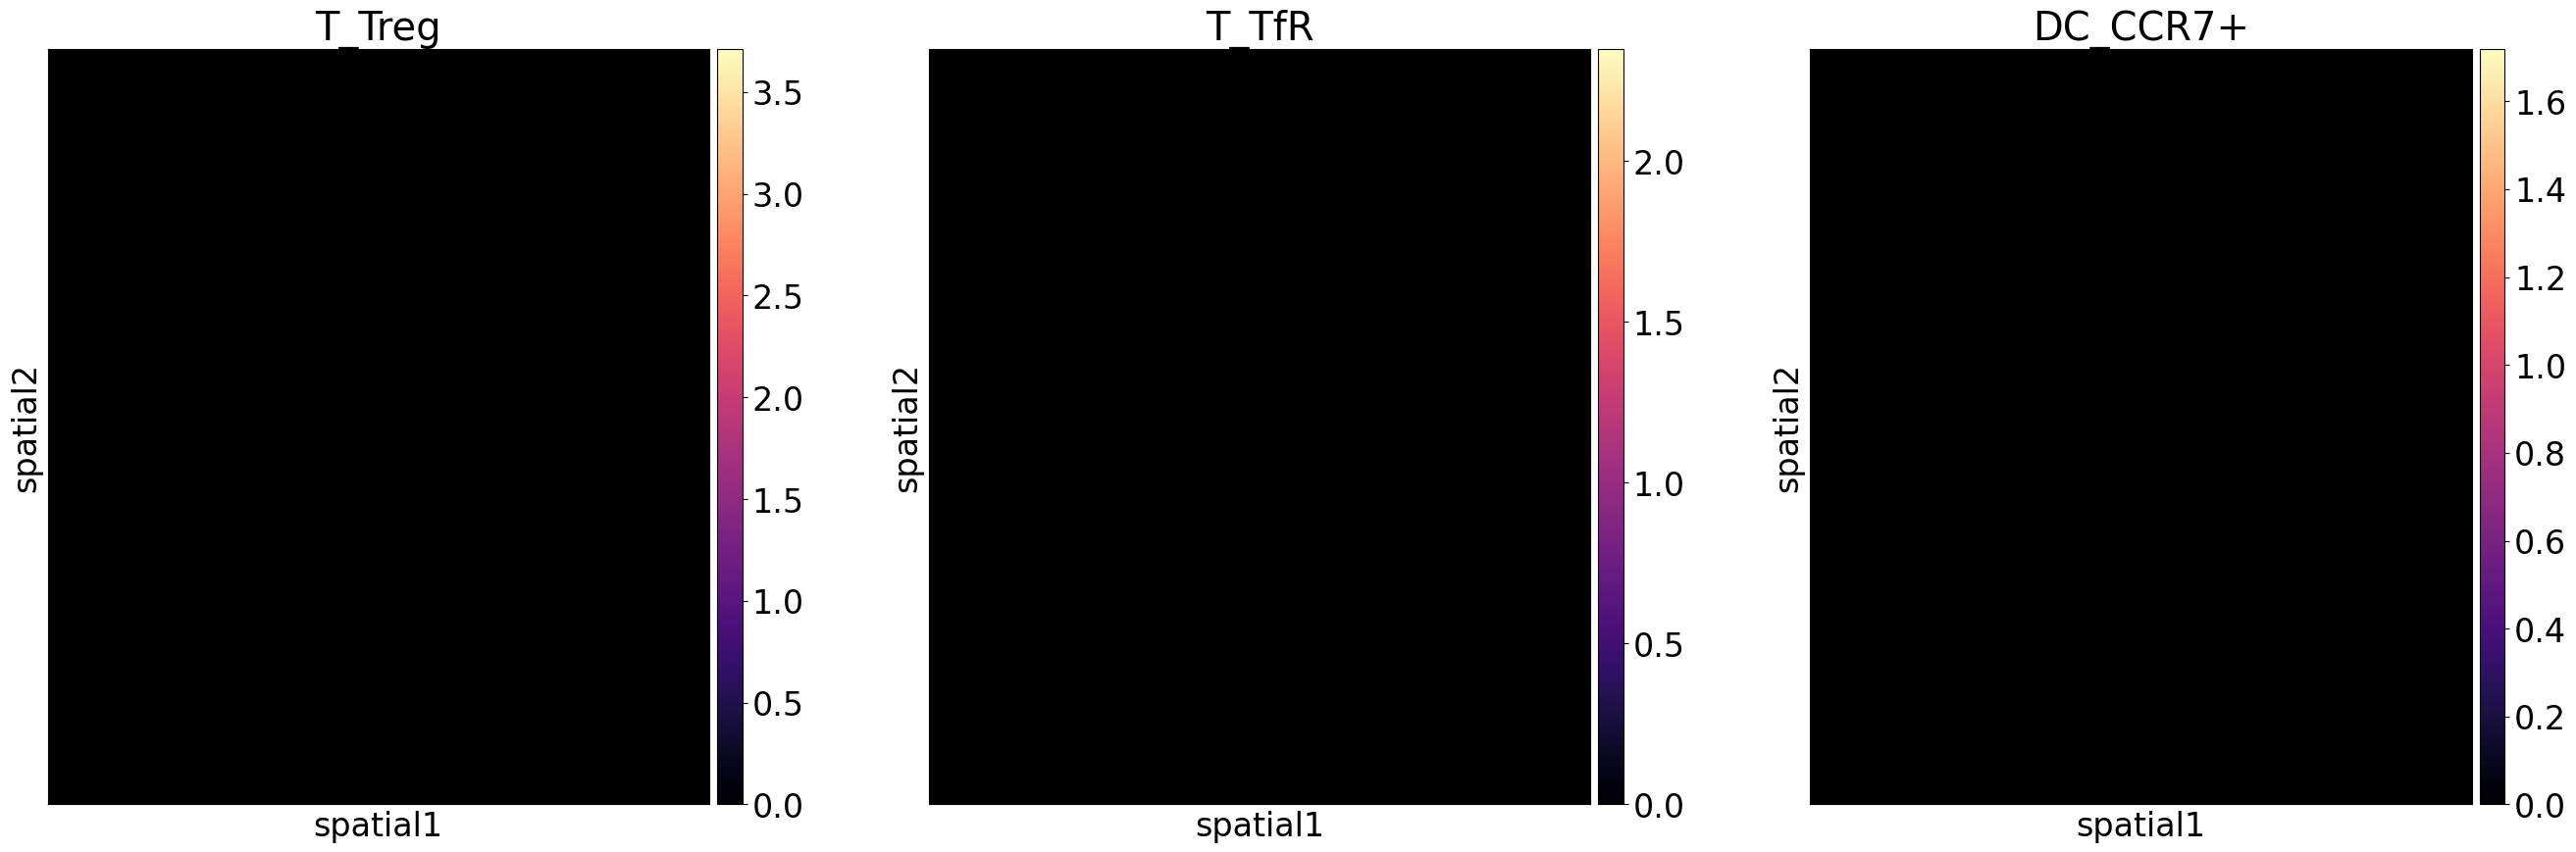

AttributeError: 'list' object has no attribute 'axes'

In [27]:
ct_list=['T_Treg', 'T_TfR', 'DC_CCR7+']

plot_spatial_factors(adata_vis_pl, ct_list, coord_small, 'Fig4D_fact_7_')

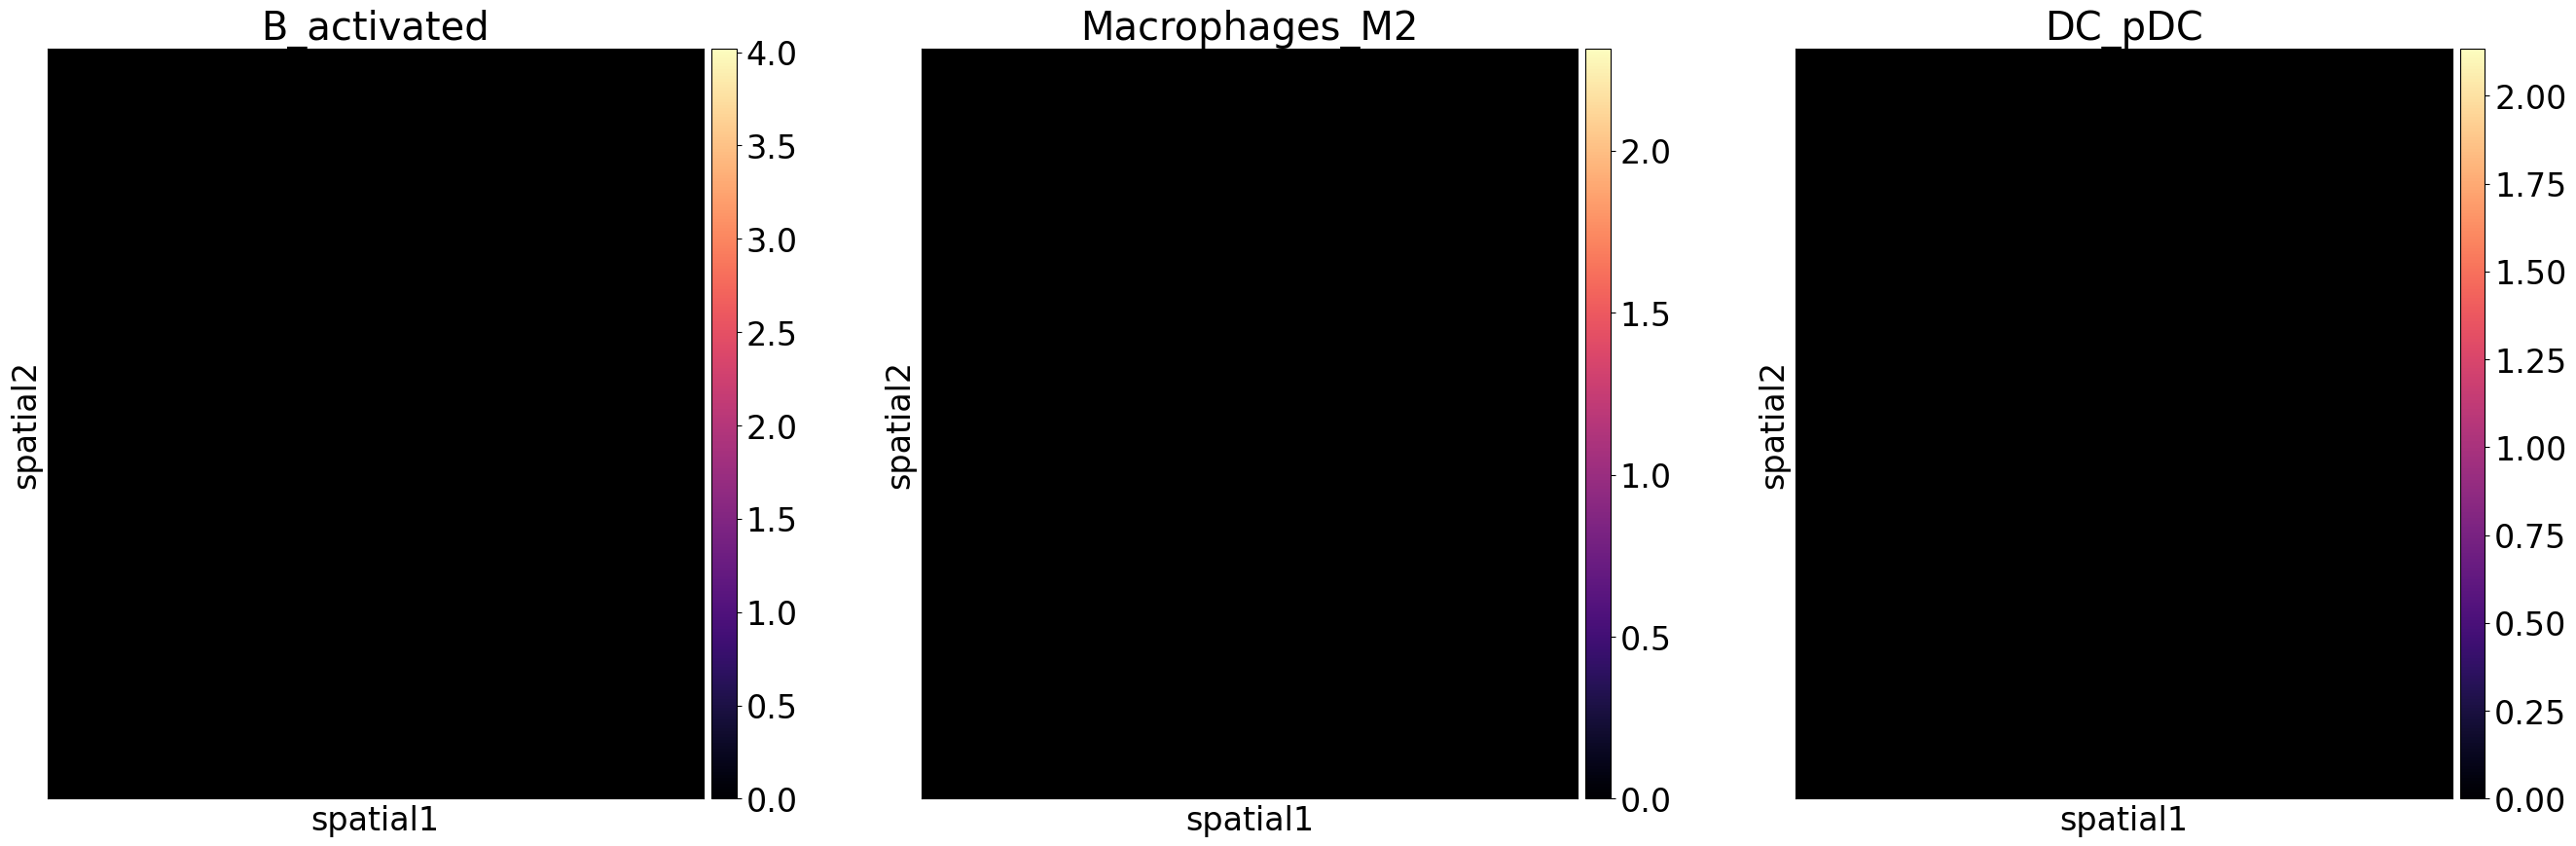

AttributeError: 'list' object has no attribute 'axes'

In [26]:
ct_list=['B_activated', 'Macrophages_M2', 'DC_pDC']

plot_spatial_factors(adata_vis_pl, ct_list, coord_small, 'Fig4D_fact_5')